In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Part 1. Dataset moons

Generate dataset and take a look at it

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

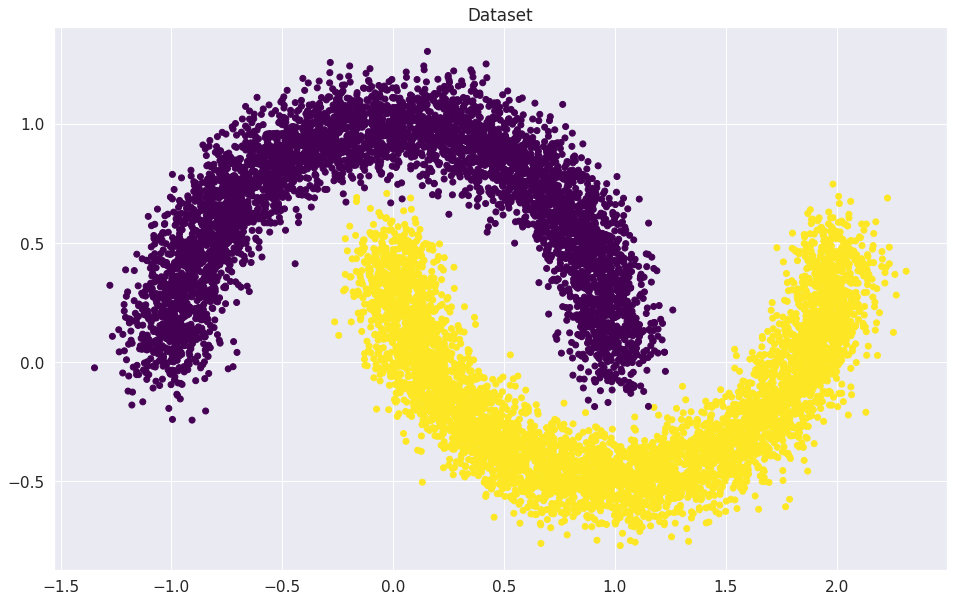

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Make train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Loading data
In PyTorch, data loading usually takes place on the fly (sometimes datasets do not fit into RAM). Two entities `Dataset` and `DataLoader' are used for this.

1. 'Dataset` loads each object individually.

2. 'DataLoader` groups objects from `Dataset` into butches.

Since our dataset is quite small, we will use `TensorDataset'. All we need is to translate from the numpy array into a tensor with the type `torch.float32'.

### Create tensors with training and test data

In [5]:
X_train_t = torch.FloatTensor(X_train)
y_train_t = torch.FloatTensor(y_train)
y_val_t = torch.FloatTensor(y_val)
X_val_t = torch.FloatTensor(X_val)

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

### Implementation of logistic regression

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features, out_features), requires_grad=True)
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features), requires_grad=True)

    def forward(self, x):
        x =  x @ self.weights
        if self.bias:
            x +=  self.bias_term
        return x

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

In [9]:
!pip install torchinfo
from torchinfo import summary
summary(linear_regression, (1, 2), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
LinearRegression                         [1, 1]                    3
Total params: 3
Trainable params: 3
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

### Implementation of the learning cycle

In [10]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch)
        loss =  loss_function(outp.view(-1), y_batch)
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.59375
Iteration: 100
Batch accuracy: 0.875
Iteration: 200
Batch accuracy: 0.8671875
Iteration: 300
Batch accuracy: 0.9140625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.9140625

Iteration: 582.Convergence. Stopping iterations.


### Visualization

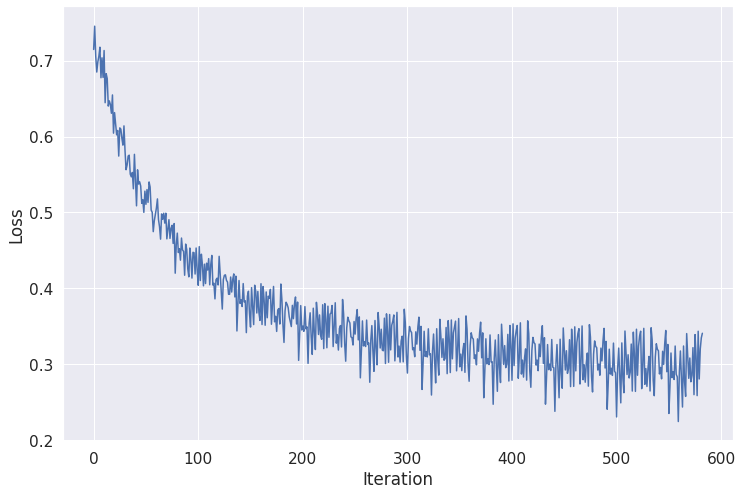

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

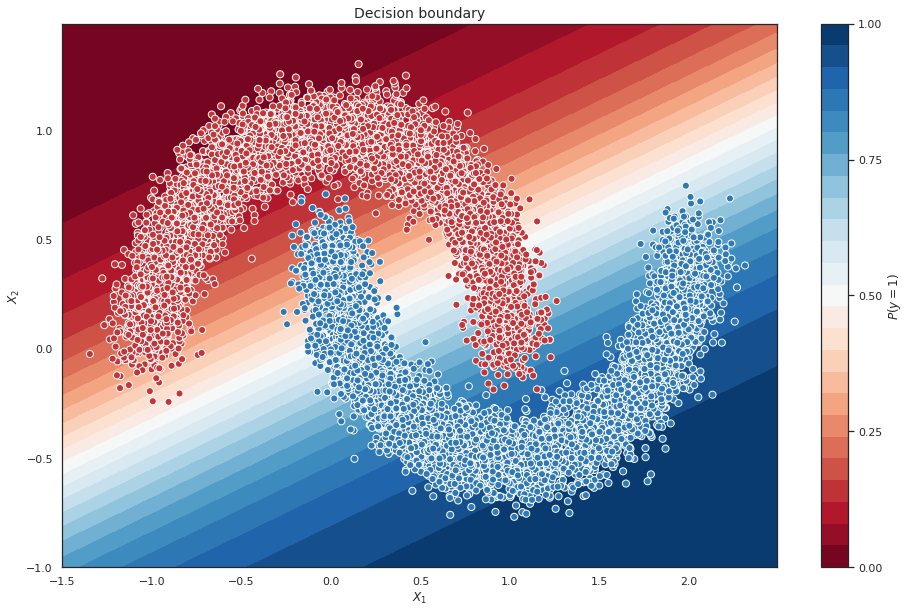

In [12]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Implement predict and calculate accuracy on test.

In [13]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        outp_1 = torch.sigmoid(model(x_batch))
        preds = (outp_1 > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [14]:
from sklearn.metrics import accuracy_score
preds = predict(val_dataloader, linear_regression)
accuracy_score(y_val_t, preds)

0.8752

# Part 2. MNIST Dataset

In [15]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
valid_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## Part 2.1. Fully connected neural networks

In [16]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Simple fully connected neural network


In [17]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [19]:
device = "cpu"

### Train loop (seriously)

In [20]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else: 
                model.eval()
                with torch.no_grad():
                    outp = torch.softmax(model(x_batch), dim=1)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8918666666666667
Loader: valid. Accuracy: 0.941
Epoch: 2
Loader: train. Accuracy: 0.9512
Loader: valid. Accuracy: 0.9562
Epoch: 3
Loader: train. Accuracy: 0.9642
Loader: valid. Accuracy: 0.967
Epoch: 4
Loader: train. Accuracy: 0.97255
Loader: valid. Accuracy: 0.9655
Epoch: 5
Loader: train. Accuracy: 0.97715
Loader: valid. Accuracy: 0.9747
Epoch: 6
Loader: train. Accuracy: 0.9796166666666667
Loader: valid. Accuracy: 0.972
Epoch: 7
Loader: train. Accuracy: 0.9818166666666667
Loader: valid. Accuracy: 0.9753
Epoch: 8
Loader: train. Accuracy: 0.9840666666666666
Loader: valid. Accuracy: 0.9762
Epoch: 9
Loader: train. Accuracy: 0.9858833333333333
Loader: valid. Accuracy: 0.977
Epoch: 10
Loader: train. Accuracy: 0.9875333333333334
Loader: valid. Accuracy: 0.9751


In [21]:
elu_accuracy = accuracy["valid"]

In [22]:
def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    )
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                else: 
                    model.eval()
                    with torch.no_grad():
                        outp = torch.softmax(model(x_batch), dim=1)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum()
                all = len(preds)
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)
    return accuracy["valid"]

In [23]:
print("Identical")
plain_accuracy = test_activation_function(Identical)
print("ReLU")
relu_accuracy = test_activation_function(nn.ReLU)
print("LeakyReLU")
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
print("Tanh")
tanh_accuracy = test_activation_function(nn.Tanh)

Identical
Epoch: 1
Loader: train. Accuracy: 0.87385
Loader: valid. Accuracy: 0.9067
Epoch: 2
Loader: train. Accuracy: 0.9020666666666667
Loader: valid. Accuracy: 0.9011
Epoch: 3
Loader: train. Accuracy: 0.9055166666666666
Loader: valid. Accuracy: 0.9074
Epoch: 4
Loader: train. Accuracy: 0.9089666666666667
Loader: valid. Accuracy: 0.9038
Epoch: 5
Loader: train. Accuracy: 0.9090333333333334
Loader: valid. Accuracy: 0.9138
Epoch: 6
Loader: train. Accuracy: 0.9121333333333334
Loader: valid. Accuracy: 0.9155
Epoch: 7
Loader: train. Accuracy: 0.9117333333333333
Loader: valid. Accuracy: 0.9129
Epoch: 8
Loader: train. Accuracy: 0.91505
Loader: valid. Accuracy: 0.9087
Epoch: 9
Loader: train. Accuracy: 0.9135166666666666
Loader: valid. Accuracy: 0.9092
Epoch: 10
Loader: train. Accuracy: 0.9137333333333333
Loader: valid. Accuracy: 0.9133
ReLU
Epoch: 1
Loader: train. Accuracy: 0.88015
Loader: valid. Accuracy: 0.9358
Epoch: 2
Loader: train. Accuracy: 0.94335
Loader: valid. Accuracy: 0.9482
Epoch: 3

### Accuracy

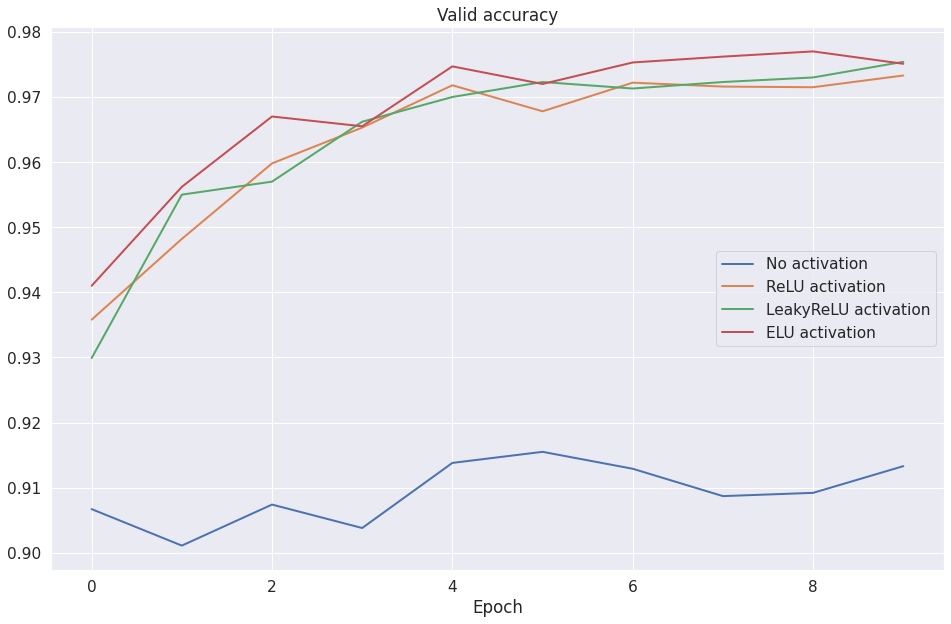

In [24]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

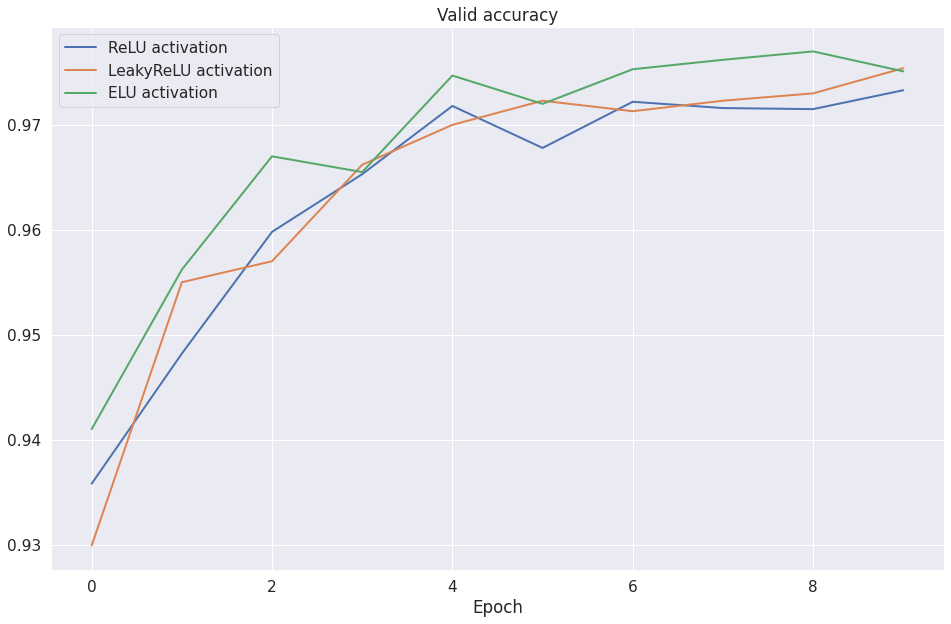

In [25]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Part 2.2 Convolutional neural networks

### Cores

In [26]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-09-29 23:04:58--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-09-29 23:04:59--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   164KB/s    in 0.3s    

2022-09-29 23:05:00 (164 KB/s) - ‘sample_photo.jpg’ saved [49337/4

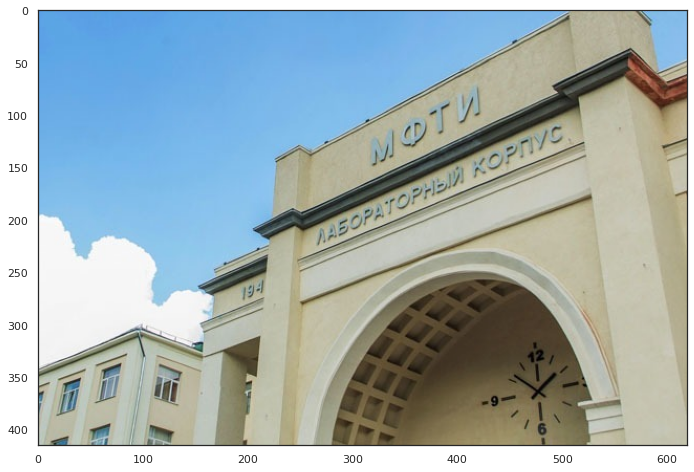

In [27]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

In [28]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

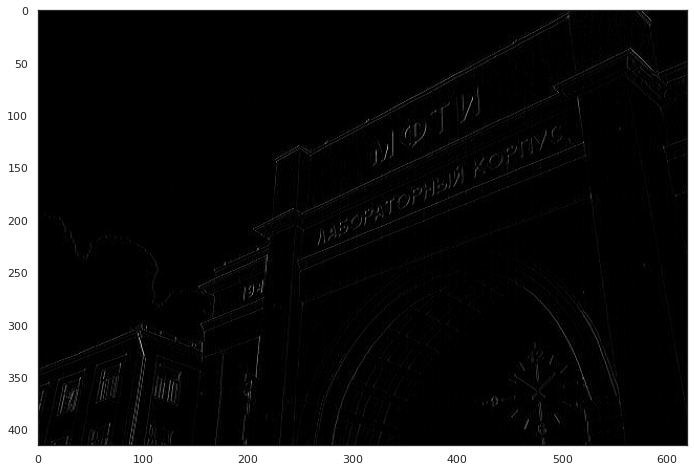

In [29]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

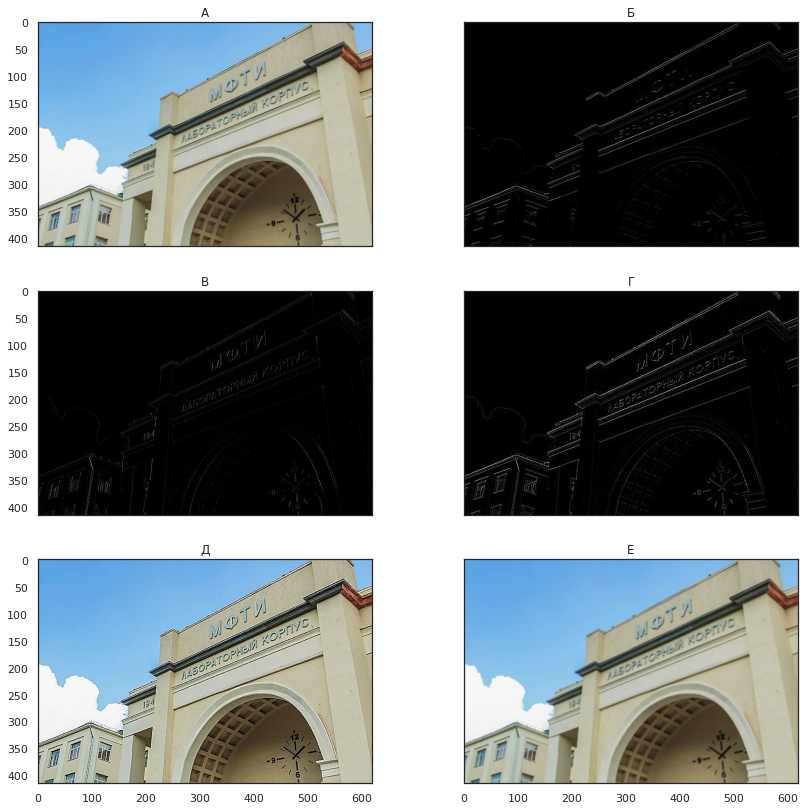

In [30]:
kernels = [
  np.array(([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
  ]), np.float32),

  np.array(([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
  ]), np.float32),

  np.array(([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
  ]), np.float32),

  np.array(([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
  ]), np.float32),

  np.array(([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
  ]), np.float32),

  np.array(([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
  ]), np.float32)
]

fig, axs = plt.subplots(nrows=3, ncols=2 ,
                        figsize=(14, 14),
                        sharey=True, sharex=True)

for pos, (kernel, ax) in enumerate(zip(kernels, axs.flatten())):
    ax.set_title(chr(ord('А') + pos))
    ax.imshow(cv2.filter2D(src=RGB_img, kernel=kernel, ddepth=-1))

### Implement LeNet

In [31]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x): 
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train CNN

In [33]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
            else:
                model.eval()
                with torch.no_grad():
                    outp = torch.softmax(model(x_batch), dim=1)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum()
            all = len(preds)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.89905
Loader: valid. Accuracy: 0.9672
Epoch: 2
Loader: train. Accuracy: 0.9726166666666667
Loader: valid. Accuracy: 0.9777
Epoch: 3
Loader: train. Accuracy: 0.9812333333333333
Loader: valid. Accuracy: 0.9832
Epoch: 4
Loader: train. Accuracy: 0.9852833333333333
Loader: valid. Accuracy: 0.9829
Epoch: 5
Loader: train. Accuracy: 0.98745
Loader: valid. Accuracy: 0.9847
Epoch: 6
Loader: train. Accuracy: 0.9896
Loader: valid. Accuracy: 0.9809
Epoch: 7
Loader: train. Accuracy: 0.9912166666666666
Loader: valid. Accuracy: 0.9851
Epoch: 8
Loader: train. Accuracy: 0.9920333333333333
Loader: valid. Accuracy: 0.9863
Epoch: 9
Loader: train. Accuracy: 0.9931
Loader: valid. Accuracy: 0.989
Epoch: 10
Loader: train. Accuracy: 0.9938
Loader: valid. Accuracy: 0.9881


In [34]:
lenet_accuracy = accuracy["valid"]

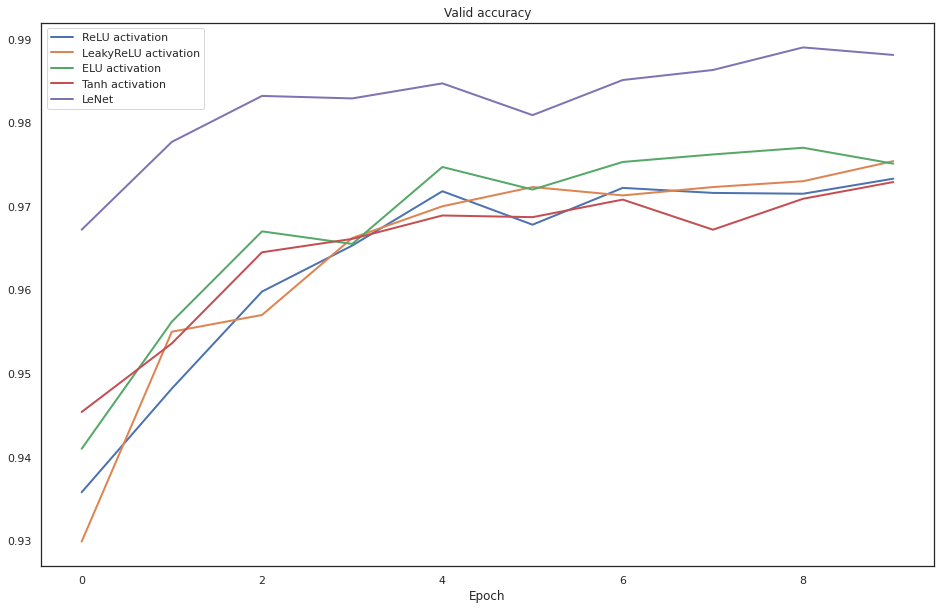

In [35]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), tanh_accuracy, label="Tanh activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()